<a href="https://colab.research.google.com/github/GokulDas027/Generative-Adversarial-Networks-GANs-/blob/master/Face_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Generation

Face Generation using DCGAN

In [0]:
import torch
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
train_on_gpu = torch.cuda.is_available()
if train_on_gpu:
  print("Training on GPU")
else:
  print("Training NOT on GPU")

Training on GPU


## Collecting DATA

We are using [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train the adversarial networks. This dataset contains over 200,000 celebrity images in RGB Color channel. 

It can be downloaded from [here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).


### Preprocessing
Since we are building a GAN, Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images.

In [3]:
!wget https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip

--2019-05-08 13:11:56--  https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.10.181
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.10.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247694507 (236M) [application/zip]
Saving to: ‘processed-celeba-small.zip’

processed-celeba-sm 100%[===================>] 236.22M  35.1MB/s    in 7.3s    

2019-05-08 13:12:04 (32.4 MB/s) - ‘processed-celeba-small.zip’ saved [247694507/247694507]



In [0]:
from zipfile import ZipFile

with ZipFile('processed-celeba-small.zip','r') as dataset:
  dataset.extractall()

### Data Loader

Defining a DataLoader for loading images into the network

In [0]:
from torchvision import datasets
from torchvision import transforms

In [0]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
  
  data_transforms = transforms.Compose([transforms.Resize(image_size),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
  
  data = datasets.ImageFolder(data_dir, transform=data_transforms)
  
  data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size)
  
  return data_loader

In [0]:
batch_size = 128
img_size = 32

celeba_train_dataloader = get_dataloader(batch_size, img_size)

## View Image

Let's Visualise Some Images from the Train Dataset

In [0]:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

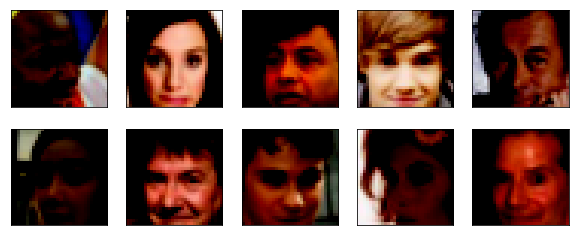

In [7]:
data_iter = iter(celeba_train_dataloader)
images,_ = data_iter.next()

plot_size = 10
fig = plt.figure(figsize=(plot_size,4))

for i in np.arange(plot_size):
  ax = fig.add_subplot(2, plot_size/2, i+1, xticks=[], yticks=[])
  imshow(images[i])

## Defining the Models


### Discriminator Model  
The Discriminator model is a Batch Normalised, Deep Covolutional Classifier without Pooling.

* The inputs are 32x32x3 tensor images.
* The output is a single value that will indicate whether a given image is real or fake.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers=[]
  
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, 
                         stride, padding, bias=False)
  
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
    
  return nn.Sequential(*layers)

In [0]:
class Discriminator(nn.Module):
  def __init__(self, conv_dim=32):
    super(Discriminator,self).__init__()
    self.conv_dim = conv_dim
    
    # 32x32 --> 16x16
    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
    # 16x16 --> 8x8
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
    # 8x8 --> 4x4
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
    # Fully connected layer : flattened img(depth*height*width)
    self.fc = nn.Linear(conv_dim*4*4*4, 1)
    
  def forward(self, x):
    # Passing to Convolutional Network
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)
    # Flattening
    out = out.view(-1, self.conv_dim*4*4*4)
    # Passing to Fully Connected Layer
    out = self.fc(out)   
    return out
    

### Generator Model
It is a Batch Normalized DeConvolution Network to Upsample the Input and Generate new Images.
*  The Generated Images have the same size as of our Training Images (32x32x3)
* The inputs to the generator are vectors of some length z_size

In [0]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  layers=[]
  
  deconv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                         stride, padding, bias=False)
  
  layers.append(deconv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
    
  return nn.Sequential(*layers)

In [0]:
class Generator(nn.Module):
  def __init__(self, z_size, conv_dim=32):
    super(Generator, self).__init__()
    self.conv_dim = conv_dim
    
    self.fc = nn.Linear(z_size,conv_dim*4*4*4)
    # 4x4 --> 8x8
    self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
    # 8x8 --> 16x16
    self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
    # 16x16 --> 32x32
    self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)
    
  def forward(self, x):
    # load x to fully connected layer
    out = self.fc(x)
    # transform linear to (batch_size,depth,height,width) dimension
    out = out.view(-1,conv_dim*4,4,4) 
    # pass the transformed data to Deconv Network
    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = F.tanh(self.deconv3(out))
    return out

## Initialise Weights to the Network
We should initialize the Weights of the convolutional and linear layers in the model to help it converge.

From the original DCGAN paper, they say:
> #### All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.



In [0]:
from torch.nn import init

def weights_init_normal(m):
  classname = m.__class__.__name__
  if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
    init.normal_(m.weight.data, 0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
      init.constant_(m.bias.data, 0.0)
  elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
    init.normal_(m.weight.data, 1.0, 0.02)
    init.constant_(m.bias.data, 0.0)

## Building the Complete network

In [0]:
def build_network(conv_dim, z_size):

  D = Discriminator(conv_dim)
  G = Generator(z_size=z_size, conv_dim=conv_dim)

  # initialize model weights
  D.apply(weights_init_normal)
  G.apply(weights_init_normal)

  print(D)
  print()
  print(G)

  return D, G

In [14]:
conv_dim = 32
z_size = 100

D, G = build_network(conv_dim, z_size)

if train_on_gpu:
  D.cuda()
  G.cuda()
  print("Model moved to GPU")
else:
  print("Model in CPU")

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

## Discriminator and Generator Loss

### Discriminator Loss
* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`.
* The Discriminator outputs 1 for real images and 0 for fake images, so we need to set up the losses to reflect that

### Generator Loss
* The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to think its generated images are real.

In [0]:
def real_loss(D_out, smooth=True):
  batch_size = D_out.size(0)
  if smooth:
    # smooth, real labels = 0.9
    labels = torch.ones(batch_size)*0.9
  else:
    # real labels = 1
    labels = torch.ones(batch_size)
  
  if train_on_gpu:
    labels = labels.cuda()
  
  # Binary Crossentropy with LogitsLoss
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)    
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  
  if train_on_gpu:
    labels = labels.cuda()
  
  # Binary Crossentropy with LogitsLoss
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)    
  return loss

## Optimizers
Define Optimizers for Generator and Discriminator

In [0]:
import torch.optim as optim

# hyperparameters
lr = 0.0001
beta1 = 0.5
beta2 = 0.999

# optimizers
d_optimizer = optim.Adam(D.parameters(), lr, betas=(beta1,beta2))
g_optimizer = optim.Adam(G.parameters(), lr, betas=(beta1,beta2))

## Training

Training involves alternating between training Discriminator and Generator.
* Train Discriminator by alternating on Real and Fake images.
* Then the Generator, which tries to fool the Discriminator have Opposing loss function ie: by computing the Discriminator loss on fake images using Flipped labels.!

In [0]:
def train(D,G, num_epochs, print_interval=50):
  
  samples=[]
  losses=[]
  
  # Get some fixed data for sampling. These are images that are held
  # constant throughout training, and allow us to inspect the model's performance
  sample_size = 16
  fixed_z = np.random.uniform(-1,1,size=(sample_size, z_size))
  fixed_z = torch.from_numpy(fixed_z).float()
  
  if train_on_gpu:
    fixed_z=fixed_z.cuda()
    
  for epoch in range(num_epochs):
    # batch loop
    for batch_i,(real_images,_) in enumerate(celeba_train_dataloader):
      
      batch_size = real_images.size(0)
      
      #################### Discriminator Training ####################
      d_optimizer.zero_grad()
      
      if train_on_gpu:
        real_images = real_images.cuda()
      
      # calculating the Discriminator loss on real images
      D_real = D(real_images)
      D_real_loss = real_loss(D_real)
      
      # Generating fake image
      z = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z = torch.from_numpy(z).float()
      if train_on_gpu:
        z = z.cuda()
        fake_images = G(z)
      
      # calculating the Discriminator loss on fake images
      D_fake = D(fake_images)
      D_fake_loss = fake_loss(D_fake)
      
      # computing total loss
      D_loss = D_real_loss + D_fake_loss
      
      D_loss.backward()
      d_optimizer.step()
      
      #################### Generator Training ####################
      for i in range(2):
        g_optimizer.zero_grad()

        # Generating Fake image
        z = np.random.uniform(-1,1,size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
          z = z.cuda()
        fake_images = G(z)

        # calculating the Discriminator loss on fake images 
        # on flipped labels
        D_fake = D(fake_images)
        G_loss = real_loss(D_fake)

        G_loss.backward()
        g_optimizer.step()
      
      # Print some loss stats
      if batch_i % print_interval == 0:
        # append discriminator loss and generator loss
        losses.append((D_loss.item(), G_loss.item()))
        # print discriminator and generator loss
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                epoch+1, num_epochs, D_loss.item(), G_loss.item()))
          
      # After Each Epoch Generate Images
      G.eval() # for Generating Images
      sample_z = G(fixed_z)
      samples.append(sample_z)
      G.train()
      
  # Save training generator samples
  with open('train_samples.pkl', 'wb') as f:
      pkl.dump(samples, f)
      
  return losses

In [18]:
for i in range(4):
  num_epochs = 5

  losses = train(D,G,num_epochs)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/    5] | d_loss: 1.5147 | g_loss: 0.6498
Epoch [    1/    5] | d_loss: 0.7037 | g_loss: 1.5957
Epoch [    1/    5] | d_loss: 0.8483 | g_loss: 1.4117
Epoch [    1/    5] | d_loss: 0.8429 | g_loss: 1.6714
Epoch [    1/    5] | d_loss: 0.9675 | g_loss: 1.1393
Epoch [    1/    5] | d_loss: 1.0689 | g_loss: 1.0600
Epoch [    1/    5] | d_loss: 1.0899 | g_loss: 1.0619
Epoch [    1/    5] | d_loss: 1.1517 | g_loss: 1.0746
Epoch [    1/    5] | d_loss: 1.1444 | g_loss: 0.9668
Epoch [    1/    5] | d_loss: 1.3426 | g_loss: 1.0676
Epoch [    1/    5] | d_loss: 1.4124 | g_loss: 0.9565
Epoch [    1/    5] | d_loss: 1.3138 | g_loss: 0.9822
Epoch [    1/    5] | d_loss: 1.2568 | g_loss: 0.9971
Epoch [    1/    5] | d_loss: 1.2868 | g_loss: 0.9648
Epoch [    1/    5] | d_loss: 1.3361 | g_loss: 0.8703
Epoch [    2/    5] | d_loss: 1.3884 | g_loss: 0.7731
Epoch [    2/    5] | d_loss: 1.3578 | g_loss: 0.8597
Epoch [    2/    5] | d_loss: 1.3655 | g_loss: 0.8372
Epoch [    2/    5] | d_loss

# Training Loss
Plotting the loss of Discriminator and Generator 

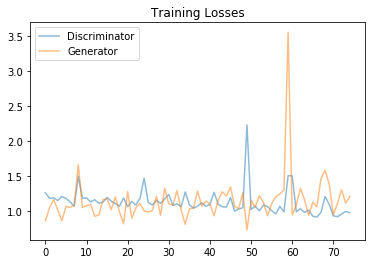

In [19]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Generating Samples from Training
view the sample images generated during training

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [0]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

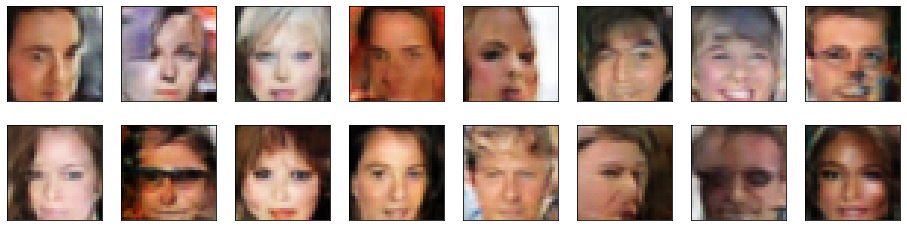

In [22]:
_ = view_samples(-1, samples)

In [0]:
# END